# Biharmonic equation solving (Time dependante)

In [40]:
using Plots
using SparseArrays
using LinearAlgebra
using BenchmarkTools
using DifferentialEquations

## Section 1 : Introduction 

This report focuses on the modeling of a steel beam using the finite difference method and explores the behavior of the beam under various boundary conditions. In addition to studying the steady-state biharmonic equation, we also consider the non-stationary or time-dependent version of the biharmonic equation. This comprehensive analysis allows us to gain insights into the dynamic response of the beam and understand the significance of different boundary conditions, particularly in relation to moments and displacements.

The biharmonic equation, as mentioned earlier, describes the bending behavior of thin plates or beams. In its non-stationary form, the biharmonic equation can be expressed as:

$$
\frac{\partial^4u}{\partial x ^4} = \frac{1}{EI} \frac{\partial^2 u}{\partial t^2} + S           
$$

where u(x, t) represents the displacement of the beam at position x and time, E is the elastic modulus and I is the second moment of area of the beam's cross section. 
I must be calculated with respect to the axis which is perpendicular to the applied loading. This equation accounts for both spatial and temporal variations in the beam's bending behavior.

In this equation, the term "EI" combines the bending stiffness properties of the material and the geometric properties of the system. It is often used in the context of mechanics and structural engineering. This equation is typical when describing the behavior of beams or plates under bending. 
In this report, I will solve the biharmonic equation for a steel beam of 7 cm of diameter, so $ E \space = \space 1.9 \times 10^7 \space N.m^{-2} $ and $I = 117.8 \space cm^2$



We seek to solve this equation numerically using the finite difference method, which discretises the domain into dx intervals. The boundary conditions specify the vibrations and the bendong moments at the ends of the beam. In this example, the beam is blocked at the ends so the boundarys are all 0. 

The bending moments at x=0 and x=L are :

$$
\frac{\partial^2u(x)}{\partial x ^2} = 0 
$$

The exterieur forces at x=0 and x=L are :

$$
u(x) = 0
$$

By solving the Biharmonic equation with these boundary conditions, we can determine the profile along the steal beam.

## Section 2: Define and Plot Initial Position and Velocity Conditions and extern force

When considering the transient behavior of the biharmonic equation, it means studying how the solution evolves over time in response to changing conditions. This is where the source function becomes important. The source function represents external influences or excitations applied to the system, and it affects the evolution of the solution over time. In physical terms, the source function models the introduction of energy, forces, or disturbances into the system.

Here, the inital position is : 

$$
    f(x) = -10
$$

Morevover, I will add an initial velocity : 

$$
    v(x) = -ax+b
$$

In this part, I model a single force acting on the beam. To do this, I will create a function that takes the form of a Gaussian function with a maximum value A representing the magnitude of the force, a width represented by the parameter σ, and located at position X0 on the beam.


$$ f(x) = A\exp{(-\frac{(x-x_0)^2}{\sigma^2})} $$

For the Biharmonic equation, this force is actually a constraint peak of magnitude A, width σ and located at position X0 on the beam. In this example, the constraint peak is located 100 cm along the beam with the maximum of force from a hammer hit with 200 N. 




In [41]:
function set_initial_condition_1(x)
    A = 1.
    l = 80
    #-A * sin((pi / l ) * x)
    return 0 * x - 10
end

set_initial_condition_1 (generic function with 1 method)

In [42]:
function set_initial_speed(x)
    A = 1.
    l = 80
    return A * sin((pi / l ) * x)
end

set_initial_speed (generic function with 1 method)

In [43]:
function source_function(x)
    X0 = 40.0
    σ = 0.8
    A = 80.
    return  - A * exp(-((x - X0)^2)/σ^2)
end

source_function (generic function with 1 method)

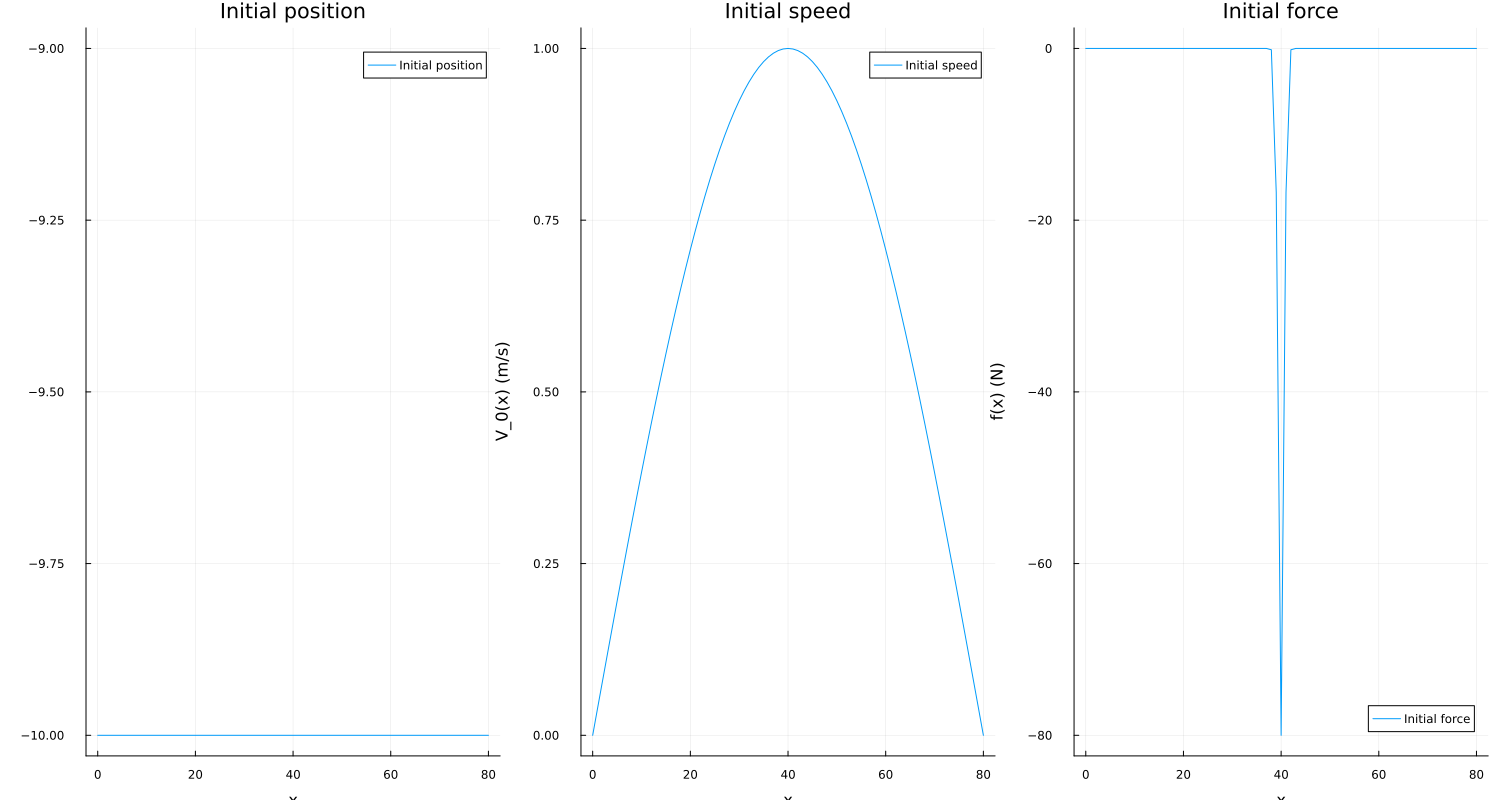

In [44]:
N = 81
L = 80.0
dx = 1
x = Vector(0.0:dx:L)

p1 = plot(x,init_t, label="Initial position")
xlabel!("x") 
ylabel!("u_0(x) (m)")
title!("Initial position")

p2 = plot(x,set_initial_speed.(x), label="Initial speed")
xlabel!("x") 
ylabel!("V_0(x) (m/s)")
title!("Initial speed")

p3 = plot(x,source_function.(x), label="Initial force")
xlabel!("x") 
ylabel!("f(x) (N)")
title!("Initial force")

plot(p1,p2,p3, size=(1500,800), layout=(1,3))

## Section 2: Define function - What function is intended here? 
 

$$ 

\frac{\partial ^2 W}{\partial t^2} = \alpha \frac{\partial ^4 W}{\partial x^4} 
$$
$$
\Leftrightarrow

\frac{\partial ^2 W}{\partial t^2} = \alpha  \times f(ddu,du,u,p,t)
$$

With the function $ f(du,u,p,t) $ for i in [1,N+1] : 

$$
ddu[1] = \frac{u_2 - u_1}{dx}
$$

$$
ddu[2] = \frac{u_3 - 2u_2 + u_1}{dx^2}
$$

$$
ddu[3:length(u)-2] = \frac{u_{i+2} - 4u_{i+1} + 6u_{i} -4u_{i-1} + u_{i-2}}{dx^4}
$$

$$
ddu[N] = \frac{u_{N+1}- 2u_N + u_{N-1}}{dx^2}
$$

$$
ddu[N+1] = \frac{u_{N+1} - u_N}{dx}
$$



### Subsection 1.2: Perform time-integration

In [45]:
function matrix(n)
    #Parameter
        l = 80.#length 
        dx = l/n
        E = 1.9 * 10^7
        I = 117.8 
       # Î± = E * I / dx^4
       α = E *I / dx^4
    
        
    
    # Build the matrix
        A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )
    
    # Coefficient that change in the  matrix 
        A[1,2] = -1/dx
        A[1,1]=  1/dx
        A[1,3] = 0.

        A[2,1] = 1/dx^2
        A[2,2] = -2/dx^2
        A[2,3] = 1/dx^2
        A[2,4] = 0.

        A[n-1, n-3] = 0.
        A[n-1,n-2] = 1/dx
        A[n-1,n-1] =-2/dx
        A[n-1,n] = 1/dx
        
        A[n,n-2] = 0.
        A[n,n-1] = -1/dx
        A[n,n]= 1/dx
    
    #time 135.690 microseconds and 65 allocations for n= 2000
        return A
    end

matrix (generic function with 1 method)

In [46]:
function biharmonic!(ddu,du,u,p,t)
    E = 1.9 * 10^7
    I = 117.8
    n = 81
    A = matrix(n)
    ddu .=  A * u + (1/E*I) * source_function.(x)
end

biharmonic! (generic function with 1 method)

In [47]:
N = 81
L = 80.0
dx = 1
x = Vector(0.0:dx:L)


init_t = set_initial_condition_1.(x)
init_dt = set_initial_speed.(x)   # initial speed
init_dt = ones(length(init_t))

t_begin  = 0.0
t_end = 10
tspan = (t_begin, t_end)
 
prob = SecondOrderODEProblem(biharmonic!,init_dt, init_t, tspan)

# original code by Yann - no algorithm specified - used default Tsit5()
# sol = DifferentialEquations.solve(prob)

# code modified by Domenico - specify algorithm for large stiff problems 
# https://docs.sciml.ai/DiffEqDocs/stable/tutorials/advanced_ode_example/
sol = DifferentialEquations.solve(prob,TRBDF2())

retcode: Success
Interpolation: 3rd order Hermite
t: 6-element Vector{Float64}:
  0.0
  0.011892664734270517
  0.13081931207697567
  0.6734560360695376
  3.049115489677802
 10.0
u: 6-element Vector{ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}:
 ([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0  …  -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0])
 ([1.0, 0.9999999999998844, 0.9999999949930917, 0.9999999852761992, 0.9999999711450004, 0.9999999528924105, 0.999999930810976, 0.9999999051884862, 0.9999998763144209, 0.9999998444751214  …  0.9999998449322465, 0.9999998766522131, 0.9999999054257542, 0.9999999309673966, 0.9999999529869307, 0.9999999711953677, 0.9999999852989577, 0.9999999949999937, 0.9999999999998851, 1.0], [-9.988107335265727, -9.988107335265727, -9.988107335290637, -9.988107335338976, -9.988107335409259, -9.988

### Subsection 2.2: Perform post-processing 

We perform post-processing in the following two ways. (1/2) Merely typing "plot(sol)". Result might be hard to understand. (2/2) Post-processing with more hand coding to plot position and velocity seperately.  

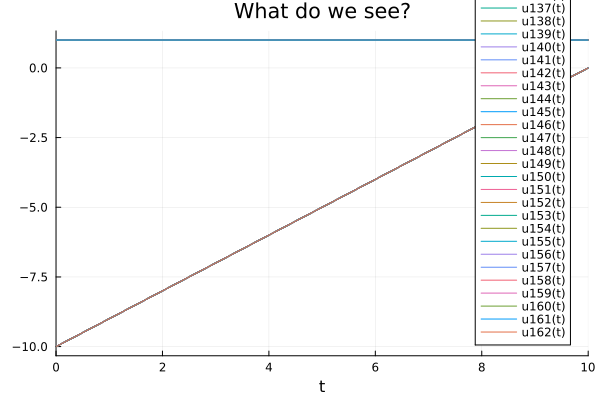

In [48]:
plot(sol)
title!("What do we see?")

### Subsection 2.3 Deflection od the beam during the time 

At the first 4 secondes, the steal beam bends downwards, then, after 4 secondes the beam deflection will start oscillations. 

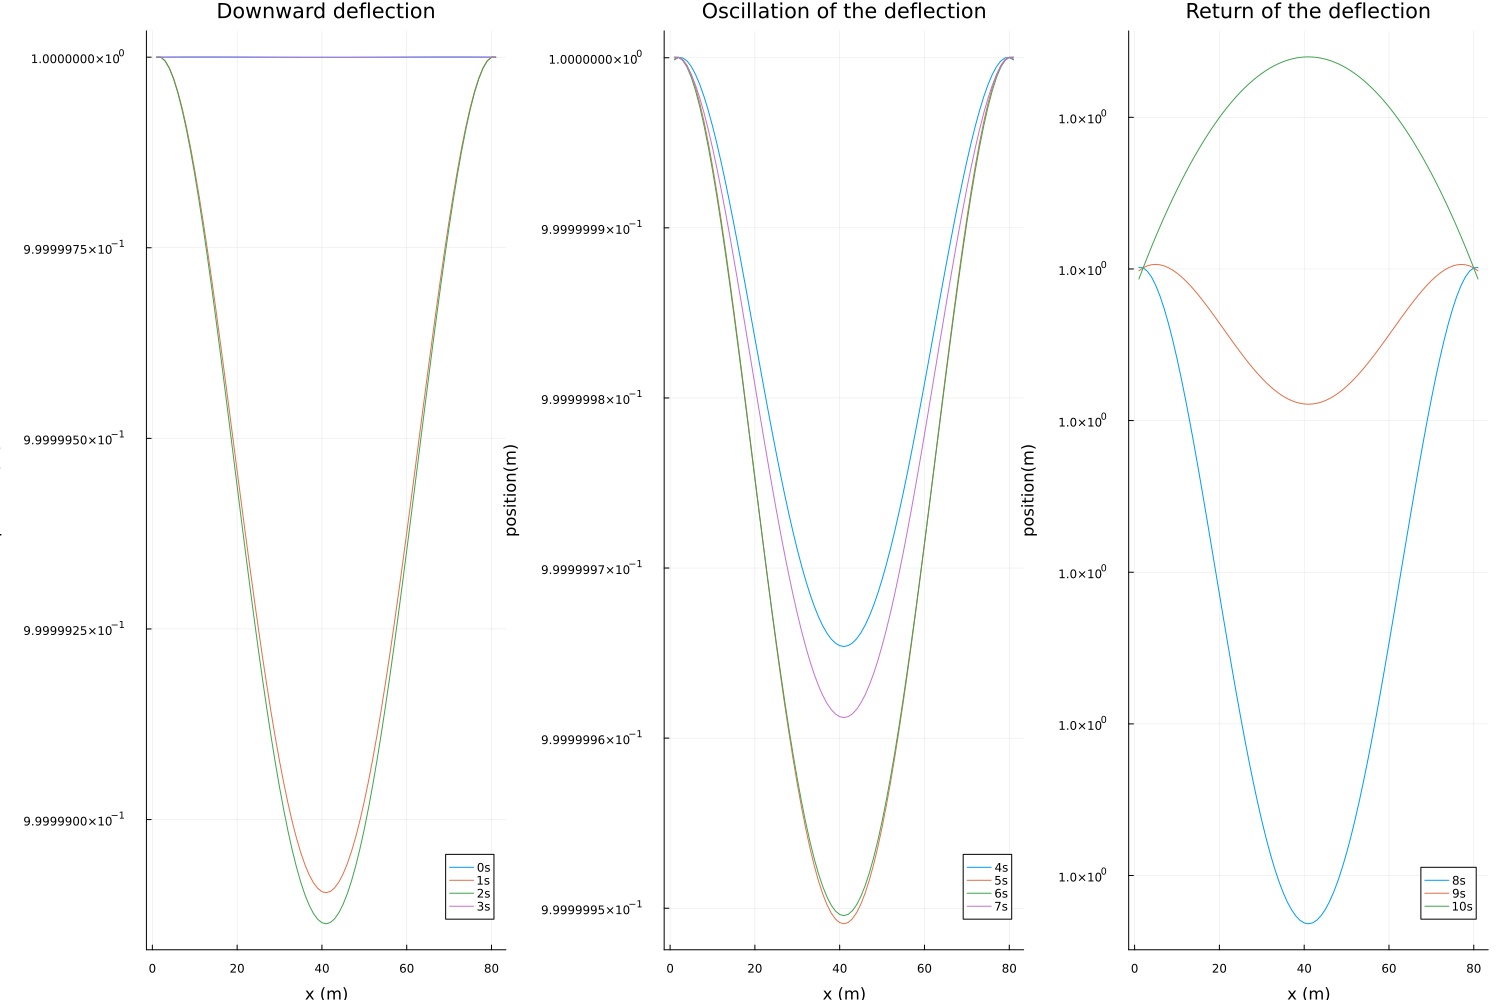

In [49]:
Nt = 10 # number of time samples 
dt = (t_end - t_begin)/Nt 

# Vector t holds 0 and is Nt+1 long 
tvec = Vector(t_begin:dt:Nt*dt)

#..interpolate solution in desired time samples 
U = zeros(2*N,length(tvec))
for k=1:length(tvec) 
  U[:,k] = sol(tvec[k])
end 

p1 = plot(U[1:N,1], label = "0s")
plot!(U[1:N,2], label = "1s")
plot!(U[1:N,3], label = "2s")
plot!(U[1:N,4], label = "3s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Downward deflection")

p2 = plot(U[1:N,5], label = "4s")
plot!(U[1:N,6], label = "5s")
plot!(U[1:N,7], label = "6s")
plot!(U[1:N,8], label = "7s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Oscillation of the deflection")

p3 = plot(U[1:N,9], label = "8s")
plot!(U[1:N,10], label = "9s")
plot!(U[1:N,11], label = "10s")
xlabel!("x (m)")
ylabel!("position(m)")
title!("Return of the deflection")


plot(p1,p2,p3, size=(1500,1000), layout=(1,3))

### Subsection 2.4: Speed of the deflection 

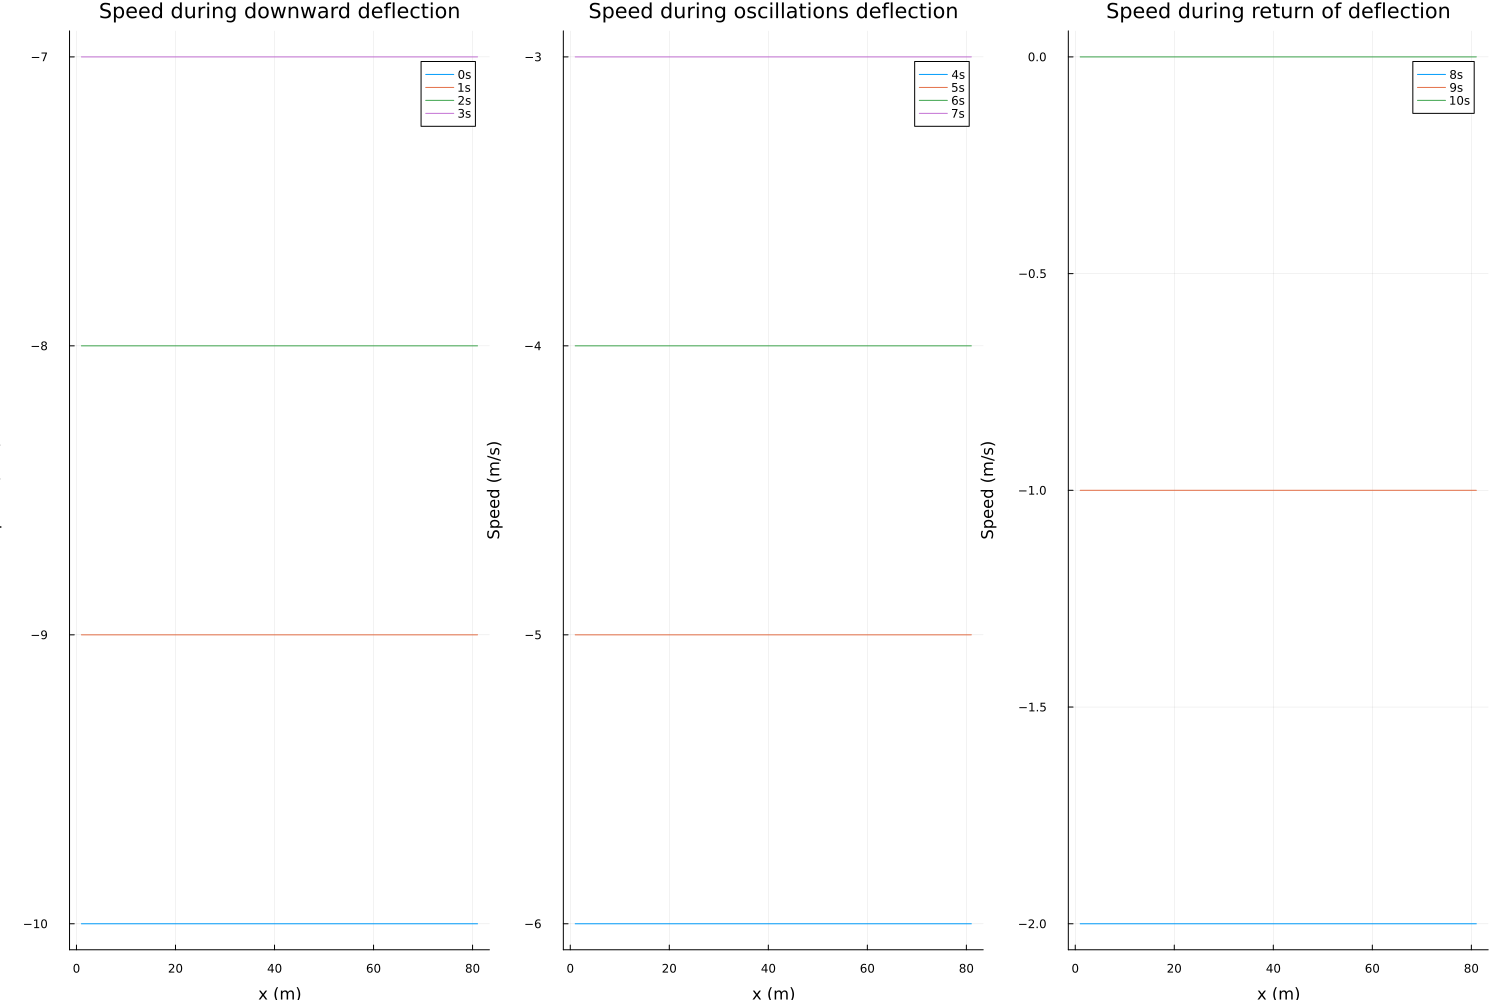

In [50]:
p1 = plot(U[N+1:end,1], label = "0s")
plot!(U[N+1:end,2], label = "1s")
plot!(U[N+1:end,3], label = "2s")
plot!(U[N+1:end,4], label = "3s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during downward deflection")


p2 = plot(U[N+1:end,5], label = "4s")
plot!(U[N+1:end,6], label = "5s")
plot!(U[N+1:end,7], label = "6s")
plot!(U[N+1:end,8], label = "7s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during oscillations deflection")

p3 = plot(U[N+1:end,9], label = "8s")
plot!(U[N+1:end,10], label = "9s")
plot!(U[N+1:end,11], label = "10s")
xlabel!("x (m)")
ylabel!("Speed (m/s)")
title!("Speed during return of deflection")

plot(p1,p2,p3, size=(1500,1000), layout=(1,3))